In [1]:
# If running in Google Colab, mount drive
print('Check if running in Colab...')
try:
    from google.colab import drive
    print('Running in Colab!')
    drive.mount('/content/drive')
    %cd '/content/drive/My Drive/CIL-FS20'
except ImportError:
    print('Running locally!')

    #Check python version
    from platform import python_version
    print('Current python version: {}'.format(python_version()))

    # Check available GPUs
    import tensorflow as tf
    no_GPUs_available = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Number of GPUs Available: {}".format(no_GPUs_available))

Check if running in Colab...
Running locally!
Current python version: 3.7.5
Number of GPUs Available: 1


In [2]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
from keras import backend as K
from keras.backend import binary_crossentropy
import keras
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from datetime import datetime

from mask_to_submission import masks_to_submission
import util

## Install the following packages
import imageio
from PIL import Image
import cv2
import natsort

Using TensorFlow backend.


## Constants

In [3]:
# Name of the current model
MODEL_NAME = 'fullyCNN_datagenerator_fixed_more_data_lr_reducing'
IMG_WIDTH = 608
IMG_HEIGHT = 608
EPOCHS = 100
STEPS_PER_EPOCH = 500
LEARNING_RATE = 0.0001
BATCH_SIZE = 8
rnd_seed = 4
np.random.seed(rnd_seed)

## Load Images

In [4]:
training_image_dir = "training_images/images/"
training_label_dir = "training_images/groundtruth/"
test_image_dir = "test_images/"

files_image = os.listdir(training_image_dir)
files_image = natsort.natsorted(files_image)
files_label = os.listdir(training_label_dir)
files_label = natsort.natsorted(files_label)
files_test = os.listdir(test_image_dir)
files_test = natsort.natsorted(files_test)
n = len(files_image)
n_test = len(files_test) 

# Load list of numpy arrays of training images and labels
print("Loading " + str(n) + " training images")
training_image_list = []
training_label_list = []
for i in range(n):
    print("Loading training image {:04d}\r".format(i)),
    training_image_list.append(imageio.imread(training_image_dir + files_image[i], pilmode="RGB"))
    training_label_list.append(imageio.imread(training_label_dir + files_label[i], pilmode="L"))

# Load list of numpy arrays of test images
print("Loading " + str(n_test) + " test images")
test_image_list = [imageio.imread(test_image_dir + files_test[i]) for i in range(n_test)]

print("TRAINING:")
print(training_image_list[0].shape)
print(training_label_list[0].shape)
print("TEST:")
print(test_image_list[0].shape)

Loading 2511 training images
Loading training image 0000
Loading training image 0001
Loading training image 0002
Loading training image 0003
Loading training image 0004
Loading training image 0005
Loading training image 0006
Loading training image 0007
Loading training image 0008
Loading training image 0009
Loading training image 0010
Loading training image 0011
Loading training image 0012
Loading training image 0013
Loading training image 0014
Loading training image 0015
Loading training image 0016
Loading training image 0017
Loading training image 0018
Loading training image 0019
Loading training image 0020
Loading training image 0021
Loading training image 0022
Loading training image 0023
Loading training image 0024
Loading training image 0025
Loading training image 0026
Loading training image 0027
Loading training image 0028
Loading training image 0029
Loading training image 0030
Loading training image 0031
Loading training image 0032
Loading training image 0033
Loading training im

Loading training image 0317
Loading training image 0318
Loading training image 0319
Loading training image 0320
Loading training image 0321
Loading training image 0322
Loading training image 0323
Loading training image 0324
Loading training image 0325
Loading training image 0326
Loading training image 0327
Loading training image 0328
Loading training image 0329
Loading training image 0330
Loading training image 0331
Loading training image 0332
Loading training image 0333
Loading training image 0334
Loading training image 0335
Loading training image 0336
Loading training image 0337
Loading training image 0338
Loading training image 0339
Loading training image 0340
Loading training image 0341
Loading training image 0342
Loading training image 0343
Loading training image 0344
Loading training image 0345
Loading training image 0346
Loading training image 0347
Loading training image 0348
Loading training image 0349
Loading training image 0350
Loading training image 0351
Loading training ima

Loading training image 0614
Loading training image 0615
Loading training image 0616
Loading training image 0617
Loading training image 0618
Loading training image 0619
Loading training image 0620
Loading training image 0621
Loading training image 0622
Loading training image 0623
Loading training image 0624
Loading training image 0625
Loading training image 0626
Loading training image 0627
Loading training image 0628
Loading training image 0629
Loading training image 0630
Loading training image 0631
Loading training image 0632
Loading training image 0633
Loading training image 0634
Loading training image 0635
Loading training image 0636
Loading training image 0637
Loading training image 0638
Loading training image 0639
Loading training image 0640
Loading training image 0641
Loading training image 0642
Loading training image 0643
Loading training image 0644
Loading training image 0645
Loading training image 0646
Loading training image 0647
Loading training image 0648
Loading training ima

Loading training image 0935
Loading training image 0936
Loading training image 0937
Loading training image 0938
Loading training image 0939
Loading training image 0940
Loading training image 0941
Loading training image 0942
Loading training image 0943
Loading training image 0944
Loading training image 0945
Loading training image 0946
Loading training image 0947
Loading training image 0948
Loading training image 0949
Loading training image 0950
Loading training image 0951
Loading training image 0952
Loading training image 0953
Loading training image 0954
Loading training image 0955
Loading training image 0956
Loading training image 0957
Loading training image 0958
Loading training image 0959
Loading training image 0960
Loading training image 0961
Loading training image 0962
Loading training image 0963
Loading training image 0964
Loading training image 0965
Loading training image 0966
Loading training image 0967
Loading training image 0968
Loading training image 0969
Loading training ima

Loading training image 1259
Loading training image 1260
Loading training image 1261
Loading training image 1262
Loading training image 1263
Loading training image 1264
Loading training image 1265
Loading training image 1266
Loading training image 1267
Loading training image 1268
Loading training image 1269
Loading training image 1270
Loading training image 1271
Loading training image 1272
Loading training image 1273
Loading training image 1274
Loading training image 1275
Loading training image 1276
Loading training image 1277
Loading training image 1278
Loading training image 1279
Loading training image 1280
Loading training image 1281
Loading training image 1282
Loading training image 1283
Loading training image 1284
Loading training image 1285
Loading training image 1286
Loading training image 1287
Loading training image 1288
Loading training image 1289
Loading training image 1290
Loading training image 1291
Loading training image 1292
Loading training image 1293
Loading training ima

Loading training image 1555
Loading training image 1556
Loading training image 1557
Loading training image 1558
Loading training image 1559
Loading training image 1560
Loading training image 1561
Loading training image 1562
Loading training image 1563
Loading training image 1564
Loading training image 1565
Loading training image 1566
Loading training image 1567
Loading training image 1568
Loading training image 1569
Loading training image 1570
Loading training image 1571
Loading training image 1572
Loading training image 1573
Loading training image 1574
Loading training image 1575
Loading training image 1576
Loading training image 1577
Loading training image 1578
Loading training image 1579
Loading training image 1580
Loading training image 1581
Loading training image 1582
Loading training image 1583
Loading training image 1584
Loading training image 1585
Loading training image 1586
Loading training image 1587
Loading training image 1588
Loading training image 1589
Loading training ima

Loading training image 1857
Loading training image 1858
Loading training image 1859
Loading training image 1860
Loading training image 1861
Loading training image 1862
Loading training image 1863
Loading training image 1864
Loading training image 1865
Loading training image 1866
Loading training image 1867
Loading training image 1868
Loading training image 1869
Loading training image 1870
Loading training image 1871
Loading training image 1872
Loading training image 1873
Loading training image 1874
Loading training image 1875
Loading training image 1876
Loading training image 1877
Loading training image 1878
Loading training image 1879
Loading training image 1880
Loading training image 1881
Loading training image 1882
Loading training image 1883
Loading training image 1884
Loading training image 1885
Loading training image 1886
Loading training image 1887
Loading training image 1888
Loading training image 1889
Loading training image 1890
Loading training image 1891
Loading training ima

Loading training image 2160
Loading training image 2161
Loading training image 2162
Loading training image 2163
Loading training image 2164
Loading training image 2165
Loading training image 2166
Loading training image 2167
Loading training image 2168
Loading training image 2169
Loading training image 2170
Loading training image 2171
Loading training image 2172
Loading training image 2173
Loading training image 2174
Loading training image 2175
Loading training image 2176
Loading training image 2177
Loading training image 2178
Loading training image 2179
Loading training image 2180
Loading training image 2181
Loading training image 2182
Loading training image 2183
Loading training image 2184
Loading training image 2185
Loading training image 2186
Loading training image 2187
Loading training image 2188
Loading training image 2189
Loading training image 2190
Loading training image 2191
Loading training image 2192
Loading training image 2193
Loading training image 2194
Loading training ima

Loading training image 2493
Loading training image 2494
Loading training image 2495
Loading training image 2496
Loading training image 2497
Loading training image 2498
Loading training image 2499
Loading training image 2500
Loading training image 2501
Loading training image 2502
Loading training image 2503
Loading training image 2504
Loading training image 2505
Loading training image 2506
Loading training image 2507
Loading training image 2508
Loading training image 2509
Loading training image 2510
Loading 94 test images
TRAINING:
(608, 608, 3)
(608, 608)
TEST:
(608, 608, 3)


## Padd Images
Training images have size 400x400 and test images have size 608x608. So we need to pad training images to same size, 
for that I use mirror padding for now.

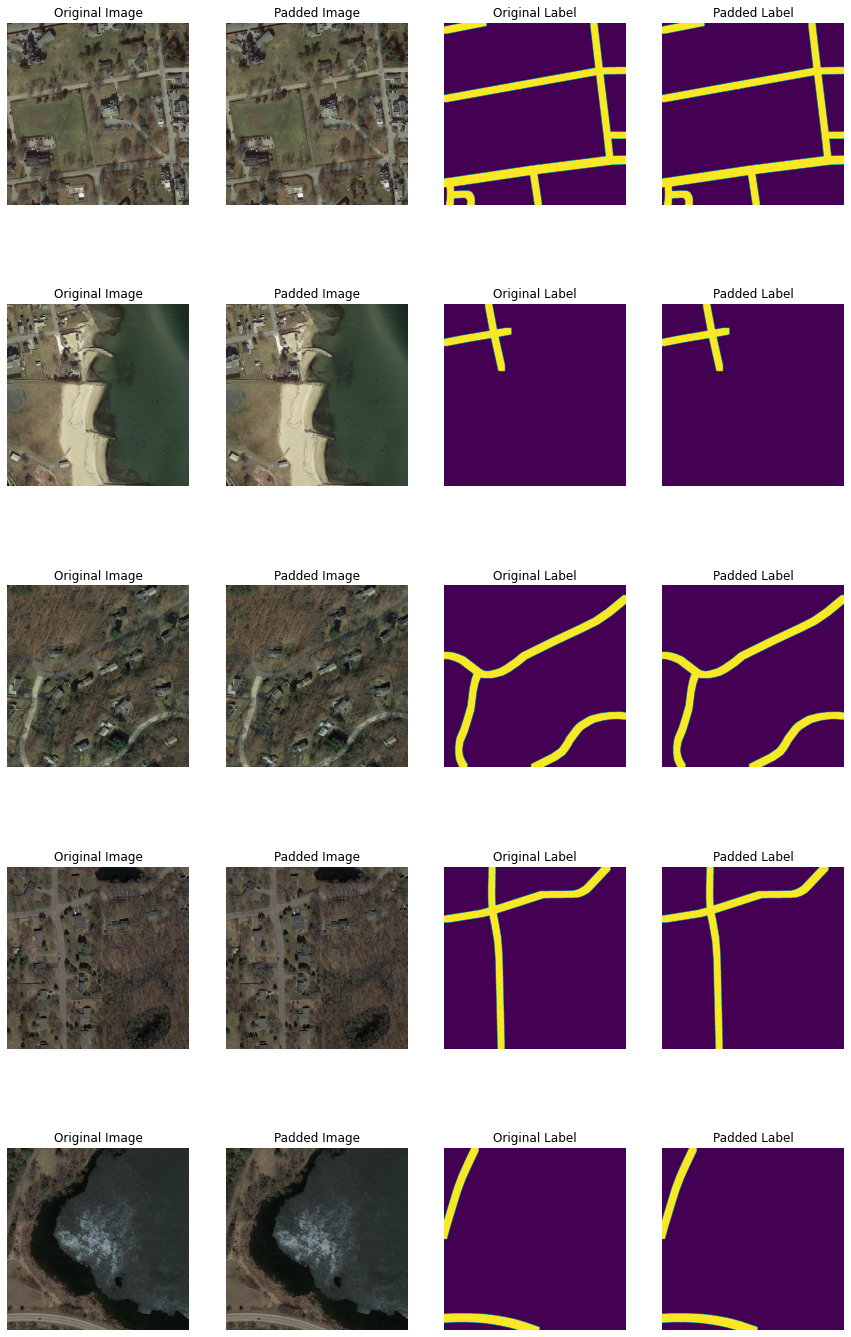

(2511, 608, 608, 3)
(2511, 608, 608, 1)


In [5]:
# Mirror padd all training images to get same size as test images
training_image_padded_list = []
training_label_padded_list = []
for i in range(n):
    training_image = training_image_list[i]
    training_label = training_label_list[i]
    height, width, _ = training_image.shape
    pad_y = int((IMG_HEIGHT - height) / 2)
    pad_x = int((IMG_WIDTH - height) / 2)
    training_image_padded_list.append(cv2.copyMakeBorder(training_image,pad_y,pad_y,pad_x,pad_x,cv2.BORDER_REFLECT))
    training_label_padded_list.append(cv2.copyMakeBorder(training_label,pad_y,pad_y,pad_x,pad_x,cv2.BORDER_REFLECT))

# Plot random Sample of images
index = random.randint(0, n-1)
num_samples = 5

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  index = random.randint(0, n-1)

  f.add_subplot(num_samples, 4, i)
  plt.imshow(training_image_list[index])
  plt.title("Original Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  plt.imshow(training_image_padded_list[index])
  plt.title("Padded Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  plt.imshow(np.squeeze(training_label_list[index]))
  plt.title("Original Label")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  plt.imshow(np.squeeze(training_label_padded_list[index]))
  plt.title("Padded Label")
  plt.axis('off')

plt.show()

# Convert image lists to numpy arrays for further processing
training_image = np.array(training_image_padded_list)
training_label = np.expand_dims(np.array(training_label_padded_list), -1)
test_image = np.array(test_image_list)
print(training_image.shape)
print(training_label.shape)

# Delete unused variables, hopefully this frees up some RAM
del training_image_list
del training_label_list
del training_image_padded_list
del training_label_padded_list

In [6]:
# Make sure label masks only have values 1 or zero
#thresh_val = 0.5
#training_label = (training_label > thresh_val).astype(np.uint8)
#training_label = training_label/255
training_label = training_label.astype(np.float32)
#print(np.unique(training_label, return_counts=True, axis=None))
print(training_label.dtype)

# Get a validation set
training_image, validation_image, training_label, validation_label = train_test_split(
    training_image, training_label, test_size=0.1, random_state=rnd_seed)

# Rescale validation images/labels and test images because generator will do the same with training data
validation_image = validation_image/255.0
validation_label = validation_label/255.0
validation_image = validation_image.astype(np.float32)
validation_label = validation_label.astype(np.float32)
print(validation_image.dtype)
test_image = test_image/255.0
test_image = test_image.astype(np.float32)
print(test_image.dtype)

float32
float32
float32


## Augment Training Data

We use the Keras Data Generator to augment our training data online while training. This is necessary because of memory consumption.

In [7]:
# We create an instance for the training images, training labels and test images
data_gen_args = dict(rescale=1.0/255.0,
                     #rotation_range=360,
                     #width_shift_range=0.05,
                     #height_shift_range=0.05,
                     #zoom_range=0.05,
                     #shear_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_generator = image_datagen.flow(
    training_image,
    batch_size=BATCH_SIZE,
    #save_to_dir="training_images_augmented/images/",
    #save_prefix="",
    #save_format="png",
    seed=seed)
mask_generator = mask_datagen.flow(
    training_label,
    batch_size=BATCH_SIZE,
    #save_to_dir="training_images_augmented/groundtruth/",
    #save_prefix="",
    #save_format="png",
    seed=seed)

# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

## Loss Function and Accuracy Metric
- Accuracy: Intersection of prediction to label image over Union
- Loss :
    - Dice Coef Loss (https://arxiv.org/pdf/1606.04797v1.pdf)
    - Soft Dice Loss (Measure of interleaving of prediction image and label image)
    - Jaccard Distance

Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99

In [8]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def soft_dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-soft_dice_coef(y_true, y_pred)

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def jaccard_coef(y_true, y_pred, smooth = 1e-12):
    intersection = K.sum(y_true * y_pred, axis=[0, 1, 2])
    sum_ = K.sum(y_true + y_pred, axis=[0, 1, 2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def combined_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)

## Model: Fully CNN built in Keras

In [9]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 608, 608, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

## Callbacks for Observations

In [10]:
#tbc=TensorBoardColab()
model_path = "./Models/{}_model.h5".format(MODEL_NAME)
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
csv_logger = CSVLogger("./Logs/{}_log.csv".format(MODEL_NAME), separator=',', append=False)
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=1e-4)
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

/home/rmenta/.local/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


## Model Training

In [11]:
opt = keras.optimizers.adam(LEARNING_RATE)
#opt = keras.optimizers.Nadam(lr=LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=dice_coef_loss,
      metrics=[iou_coef])

In [12]:
history = model.fit_generator(train_generator,
                              validation_data =(validation_image, validation_label),
                              steps_per_epoch=STEPS_PER_EPOCH,
                              epochs=EPOCHS,
                              callbacks = [checkpointer, csv_logger, lr_reducer, early_stopper])

Epoch 1/100
500/500 [==============================] - 399s 798ms/step - loss: 0.0832 - iou_coef: 0.2295 - val_loss: 0.0324 - val_iou_coef: 0.3107

Epoch 00001: val_loss improved from inf to 0.03244, saving model to ./Models/fullyCNN_datagenerator_fixed_more_data_lr_reducing_model.h5
Epoch 2/100
500/500 [==============================] - 388s 775ms/step - loss: 0.0396 - iou_coef: 0.3104 - val_loss: 0.0242 - val_iou_coef: 0.3647

Epoch 00002: val_loss improved from 0.03244 to 0.02418, saving model to ./Models/fullyCNN_datagenerator_fixed_more_data_lr_reducing_model.h5
Epoch 3/100
500/500 [==============================] - 388s 775ms/step - loss: 0.0288 - iou_coef: 0.3590 - val_loss: 0.0233 - val_iou_coef: 0.3651

Epoch 00003: val_loss improved from 0.02418 to 0.02335, saving model to ./Models/fullyCNN_datagenerator_fixed_more_data_lr_reducing_model.h5
Epoch 4/100
500/500 [==============================] - 388s 776ms/step - loss: 0.0241 - iou_coef: 0.3856 - val_loss: 0.0199 - val_iou_coe

Epoch 32/100
500/500 [==============================] - 416s 831ms/step - loss: 0.0135 - iou_coef: 0.5560 - val_loss: 0.0131 - val_iou_coef: 0.5442

Epoch 00032: val_loss did not improve from 0.01302
Epoch 33/100
500/500 [==============================] - 416s 832ms/step - loss: 0.0138 - iou_coef: 0.5540 - val_loss: 0.0130 - val_iou_coef: 0.5481

Epoch 00033: val_loss did not improve from 0.01302

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
Epoch 34/100
500/500 [==============================] - 416s 832ms/step - loss: 0.0135 - iou_coef: 0.5512 - val_loss: 0.0130 - val_iou_coef: 0.5474

Epoch 00034: val_loss improved from 0.01302 to 0.01302, saving model to ./Models/fullyCNN_datagenerator_fixed_more_data_lr_reducing_model.h5
Epoch 35/100
500/500 [==============================] - 416s 833ms/step - loss: 0.0137 - iou_coef: 0.5544 - val_loss: 0.0131 - val_iou_coef: 0.5463

Epoch 00035: val_loss did not improve from 0.01302
Epoch 36/100
500/500 [=======

KeyboardInterrupt: 

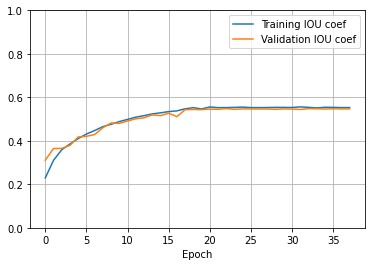

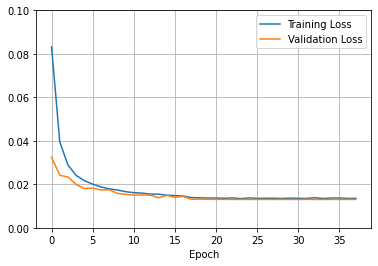

In [18]:
# Show a training report
training_info = pd.read_csv('./Logs/{}_log.csv'.format(MODEL_NAME), header=0)

acc1, = plt.plot(training_info['epoch'], training_info['iou_coef'])
acc2, = plt.plot(training_info['epoch'], training_info['val_iou_coef'])
plt.legend([acc1, acc2], ['Training IOU coef', 'Validation IOU coef'])
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.grid(True)
plt.show()

loss1, = plt.plot(training_info['epoch'], training_info['loss'])
loss2, = plt.plot(training_info['epoch'], training_info['val_loss'])
plt.legend([acc1, acc2], ['Training Loss', 'Validation Loss'])                            
plt.xlabel('Epoch')
plt.ylim(0,0.1)
plt.grid(True)

plt.show()

## Model Evaluation

In [14]:
# Kaggle scores on validation images (mean score per image and overall mean score)
model = load_model("./Models/{}_model.h5".format(MODEL_NAME), custom_objects={'dice_coef_loss': dice_coef_loss, 'iou_coef': iou_coef})
y_pred = model.predict(validation_image, batch_size=4, verbose=1)
scores = util.validate_kaggle_score(validation_label, y_pred)
print(scores)
print(sum(scores)/len(scores))

252/252 [==============================] - 7s 28ms/step
[0.48648648648648646, 0.8720379146919431, 0.0, 0.7058823529411764, 0.9647887323943661, 0.1923076923076923, 0.9176470588235294, 0.8596491228070176, 0.8588235294117647, 0.5846153846153846, 0.8633540372670808, 0.9464285714285715, 0.9102244389027431, 0.8661417322834646, 0.894484412470024, 0.9050279329608938, 0.5797101449275363, 0.8536312849162011, 0.8260869565217391, 0.9608938547486034, 0.9, 0.38095238095238093, 0.7826086956521738, 0.6697459584295612, 0.8682170542635658, 0.8595041322314049, 0.6729857819905214, 0.9141193595342068, 0.8761609907120742, 0.8942598187311179, 0.7832699619771863, 0.9801324503311258, 0.8995215311004785, 0.9246231155778895, 0.9166666666666667, 0.9537892791127541, 0.48148148148148145, 0.38683127572016457, 0.7673267326732673, 0.6175637393767706, 0.896551724137931, 0.776255707762557, 0.8228571428571428, 0.25, 0.5894736842105264, 0.9366053169734151, 0.8759124087591241, 0.6017699115044248, 0.8735632183908045, 0.8648

In [29]:
model = load_model("./Models/{}_model.h5".format(MODEL_NAME), custom_objects={'dice_coef_loss': dice_coef_loss, 'iou_coef': iou_coef})
#model.evaluate(test_images, test_label)
predictions = model.predict(test_image, batch_size=4, verbose=1)

94/94 [==============================] - 3s 29ms/step


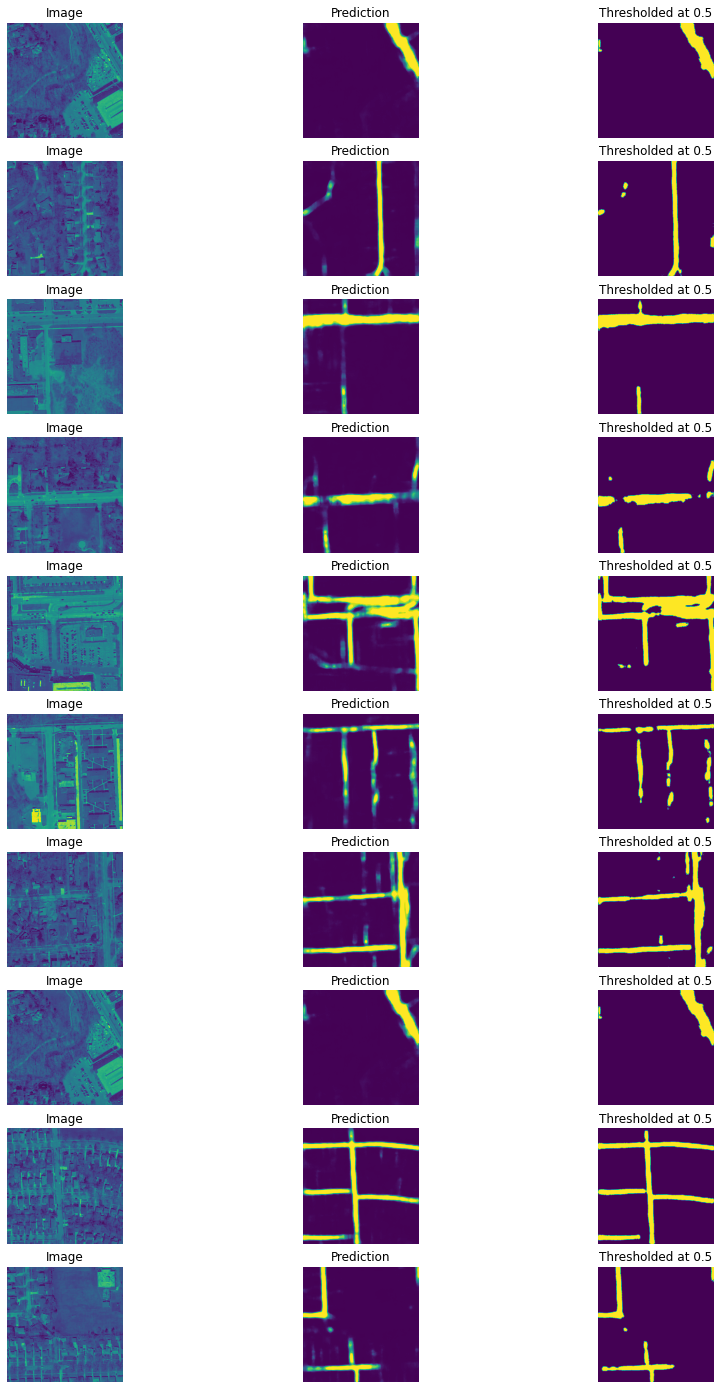

In [30]:
thresh_val = 0.5
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

index = random.randint(0, len(predictions)-1)
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*3, 3):
  index = random.randint(0, len(predictions)-1)

  f.add_subplot(num_samples, 3, i)
  plt.imshow(test_image[index][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+1)
  plt.imshow(np.squeeze(predictions[index][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+2)
  plt.imshow(np.squeeze(predicton_threshold[index][:,:,0]))
  plt.title("Thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()

## Create Submission File
Multiply image by 255 and convert to unit8 before storing s.t. it gets read out correctly by mask_to_submission!

In [ ]:
predictions = np.squeeze(predictions*255)
predictions = predictions.astype(np.uint8)
result_dir = './Results/Prediction_Images/{}/'.format(MODEL_NAME)
os.makedirs(result_dir, exist_ok=True)

#print(predictions.shape)
#[print(predictions[i].shape) for i in range(n_test)]

[imageio.imwrite(result_dir + files_test[i], predictions[i],) for i in range(n_test)]
files_predictions = os.listdir(result_dir)
files_predictions = [result_dir + files_predictions[i] for i in range(n_test)]
masks_to_submission('./Results/Submissions/{}.csv'.format(MODEL_NAME), *files_predictions)
print('Submission ready')

./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_211.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_49.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_10.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_136.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_92.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_177.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_76.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_64.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_23.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_80.png
./Results/Prediction_Images/fullyCNN_datagenerator_fixed_more_data_lr_reducing/test_51.